In [295]:
# Covid 19 SEIR model with quarantine and asymptomatic_but_infectious - SEIQRA model
# Ken Muldrew March 28, 2019
# Adapted from Peng, et al., Epidemic analysis of COVID-19 in China by dynamical modeling, arXiv:2002.06563 [q-bio.PE]
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline

'<img src="covid19.gif"/>'

$$\frac{dS}{dt}= -\left (  \frac{R_0}{T_{inf}} \right ) S \left ( I + A \right )-\alpha \cdot S$$

$$\frac{dE}{dt}= \left (  \frac{R_0}{T_{inf}} \right ) S \left ( I + A \right )-\frac{E}{T_{inc}}-asymp \cdot E$$

$$\frac{dP}{dt}= \alpha \cdot S$$

$$\frac{dI}{dt}= \frac{E}{T_{inc}}-\frac{I}{T_{inf}}$$

$$\frac{dA}{dt}= asymp\cdot E-\frac{A}{T_{clr}}$$

$$\frac{dQ}{dt}=\frac{I}{T_{inf}}-k_{recv}\cdot Q-k_{decd}\cdot Q$$

$$\frac{dR}{dt}=k_{recv}\cdot Q+\frac{A}{T_{clr}}$$

$$\frac{dD}{dt}=k_{decd}\cdot Q$$

In [252]:
# S = susceptible population
# P = isolated population (susceptible but in social isolation)
# I = infectious population
# E = exposed population (infected but not yet infectious)
# A = asymptomatic but infectious population
# Q = quarantined infectious population (hospitalized)
# R = recovered population (immune)
# D = deceased population
# R_0 = reproduction number (function of density of susceptibles sqrt(S/N)*R_0) *should subtract deceased
# T_inf = infectious period
# T_inc = incubation period
# T_clr = infectious period for asymptomatics
# alpha_t = rate of social isolation
# k_recv = rate of recovery
# k_decd = death rate (function of Q plus baseline) if Q > threshold, k_decd = 10 x k_decd
# asymp = rate of susceptible to asymptomatic infectious

In [314]:
# Susceptible equation (people at risk who are socially active)
def dS_dt(N, S, P, I, A, R_0, T_inf, alpha_t):
    if P < 0: # no negative populations
        alpha_t = 0
    R_0 = math.sqrt(S) * R_0
    if (I + A) < (1 / (N*1.5)): # need at least one infectious person to keep spreading
        return -(alpha_t * S) # out to P
    else:
        return -((R_0 / T_inf) * (I + A) * S) - (alpha_t * S) # out to I & A & P

# isolated equation (people at risk who are socially isolated)
def dP_dt(S, P, alpha_t):
    if P < 0:
        alpha_t = 0
    return alpha_t * S

# Exposed equation (people who are infected (asymptomatic) but not yet infectious)
def dE_dt(N, S, E, I, A, R_0, T_inf, T_inc, asymp):
    R_0 = math.sqrt(S) * R_0
    if I < (1 / (N*1.5)): # need at least 1 infected person to spread disease (or 1.5 ? wtf)
        return -(E / T_inc)
    else:
        return ((R_0 / T_inf) * (I + A) * S) - (E / T_inc) - (asymp * E) # in from S, out to E & A

# Infected equation (people who are sick and infectious)
def dI_dt(I, E, T_inc, T_inf):
    return (E / T_inc) - (I / T_inf) # in from E, out to Q

# Asymptomatic/Infectious equation (people who are asymptomatic and infectious)
def dA_dt(A, E, T_clr, asymp):
    return (asymp * E) - (A / T_clr) # in from E, out to R

# Quarantined equation (people who are sick but quarantined)
def dQ_dt(I, Q, T_inf, k_recv, k_decd,ICU_overload):
    if Q > ICU_overload:
        k_decd = 10 * k_decd
    return I / T_inf - k_recv * Q - k_decd * Q

# Recovered equation (people who have recovered)
def dR_dt(Q, A, k_recv, T_clr):
    return k_recv * Q + (A / T_clr) # in from Q & A

# Deceased equation (people who are dead)
def dD_dt(Q, k_decd,ICU_overload):
    if Q > ICU_overload:
        k_decd = 10 * k_decd
    return k_decd * Q

def SEIR_model(t, y, R_0, T_inf, T_inc, T_clr, k_recv, k_decd, alpha_t, asymp, ICU_overload, N):
    
    if callable(alpha_t):
        isolation = alpha_t(t)
    else:
        isolation = alpha_t
    
    S, P, E, I, A, Q, R, D = y
    S_out = dS_dt(N, S, P, I, A, R_0, T_inf, isolation)
    P_out = dP_dt(S, P, isolation)
    E_out = dE_dt(N, S, E, I, A, R_0, T_inf, T_inc, asymp)
    I_out = dI_dt(I, E, T_inc, T_inf)
    A_out = dA_dt(A, E, T_clr, asymp)
    Q_out = dQ_dt(I, Q, T_inf, k_recv, k_decd, ICU_overload)
    R_out = dR_dt(Q, A, k_recv, T_clr)
    D_out = dD_dt(Q, k_decd, ICU_overload)
    return [S_out, P_out, E_out, I_out, A_out, Q_out, R_out, D_out]

In [315]:
N = 1000000  # Population size
n_infected = 1
max_days = 200

# State at time = 0 for SEIR model
a = (N - n_infected)/ N
b = 0
c = 0
d = n_infected / N
e = 0
f = 0
g = 0
h = 0.

In [316]:
def plot_model(solution, title='SEIR model'):
    sus, iso, exp, inf, asy, qua, rec, dec = solution.y

    f = plt.figure(figsize=(8,5)) 
    plt.plot(sus, 'b', label='Susceptible');
    plt.plot(iso, 'g', label='Isolated');
    plt.plot(exp, 'y', label='Exposed');
    plt.plot(inf, 'r', label='Infected');
    plt.plot(asy, 'r', linestyle='dashed', label='Asymptomatic');
    plt.plot(qua, 'c', label='Quarantined');
    plt.plot(rec, 'm', label='Recovered');
    plt.plot(dec, 'k', label='Deceased');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.ylabel("Fraction of population", fontsize=10);
    plt.legend(loc='best');

81.86 % recovery
9.59 % mortality


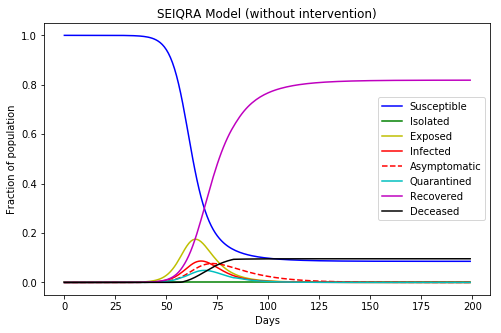

In [317]:
T_inc = 5.5  # average incubation period
T_inf = 2.9  # average infectious period before quarantine
T_clr = 14.0 # average clearance period for asymptomatics
k_recv = 0.5  # recovery rate
k_decd = 0.01  # mortality rate
R_0 = 2.9  # reproduction number
alpha_t = 0  # isolation coeff
asymp = 0.05 # exposed to asymptomatic coeff
ICU_overload = 0.02 # threshold where hospitals can't keep up

sol = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d, e, f, g, h], args=(R_0, T_inf, T_inc, T_clr, k_recv, k_decd, alpha_t, asymp, ICU_overload, N), 
                t_eval=np.arange(max_days))

plot_model(sol, 'SEIQRA Model (without intervention)')
print("{:.2f}".format(sol.y[6][199] * 100),'% recovery')
print("{:.2f}".format(sol.y[7][199] * 100),'% mortality')

83.40 % recovery
2.55 % mortality


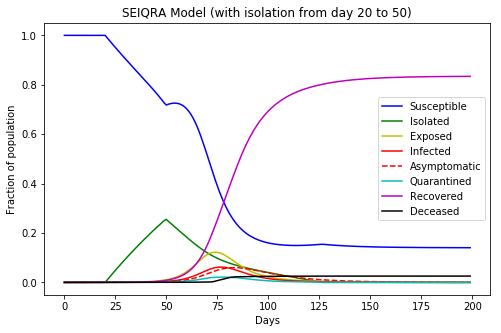

In [306]:
T_inc = 5.5  # average incubation period
T_inf = 2.9  # average infectious period before quarantine
k_recv = 0.9  # recovery rate
k_decd = 0.01  # mortality rate
R_0 = 2.9  # reproduction number without intervention
alpha_0 = 0 # no isolation
alpha_t = 0.01 # social distancing
intervention_day1 = 20
intervention_day2 = 50

def time_varying_isolation(t):
    if t < intervention_day1:
        return alpha_0
    elif t < intervention_day2:
        return alpha_t
    else:
        return -alpha_t

sol2 = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d, e, f, g, h], args=(R_0, T_inf, T_inc, T_clr, k_recv, k_decd, time_varying_isolation, asymp, ICU_overload, N), 
                t_eval=np.arange(max_days))

plot_model(sol2, f'SEIQRA Model (with isolation from day {intervention_day1} to {intervention_day2})')
print("{:.2f}".format(sol2.y[6][199] * 100),'% recovery')
print("{:.2f}".format(sol2.y[7][199] * 100),'% mortality')

73.34 % recovery
0.64 % mortality


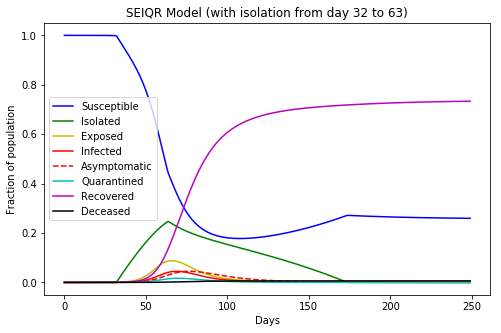

In [309]:
max_days = 250
intervention_day1 = 32
intervention_day2 = 63
sol2 = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d, e, f, g, h], args=(R_0, T_inf, T_inc, T_clr, k_recv, k_decd, time_varying_isolation, asymp, ICU_overload, N), 
                t_eval=np.arange(max_days))

plot_model(sol2, f'SEIQR Model (with isolation from day {intervention_day1} to {intervention_day2})')
print("{:.2f}".format(sol2.y[6][249] * 100),'% recovery')
print("{:.2f}".format(sol2.y[7][249] * 100),'% mortality')